# **Advanced Lane Finding** 
***
As a part of the Udacity Self Driving Car Engineer Nanodegree program, we use computer vision to implement to again implement lane finding, but using a more advanced set of techniques than the first project of the course.

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. [Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.](#camera_calibration)
2. [Apply a distortion correction to raw images.](#apply_distortion)
3. [Use color transforms, gradients, etc., to create a thresholded binary image.](#create_binary)
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

<a id='camera_calibration'></a>

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def getpoints(imgfiles, nx, ny, drawcorners=False, allowoffbyone=True):
    '''Construct image points and object points from chessboard calibration image files'''
    imgpoints = []
    objpoints = []
    imgsize = None

    # prepare constant object points to append if corners found in an image
    objp = np.zeros((nx*ny,3), dtype=np.float32)
    objp[:,:2] = np.mgrid[:nx,:ny].T.reshape(-1,2)

    # Process images and build imgpoints list
    for imgfile in imgfiles:
        
        img = mpimg.imread(imgfile)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        this_imgsize = gray.shape[::-1]
        if imgsize is None:
            imgsize = this_imgsize # store (width, height) for use by cv2.calibrateCamera()
        else:
            msg = 'Size mismatch: {}. {} != {}.'.format(imgfile, imgsize, gray.shape[::-1])
            # a couple of the images have an extra pixel in each dimension, but it should be
            # ok since the corners are within the smaller dimension range?
            # Thus, let's optionally allow it.
            allowedsizes = [this_imgsize]
            if allowoffbyone:
                allowedsizes.append((this_imgsize[0] - 1, this_imgsize[1] - 1))
            assert imgsize in allowedsizes, msg

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners found, draw corners, and append corresponding img/obj points
        if ret:
            
            # Optionally plot the images with corners drawn
            if drawcorners:
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
                plt.title(imgfile + ' corners')
            
            objpoints.append(objp)
            imgpoints.append(corners)
            
    
    return objpoints, imgpoints, imgsize

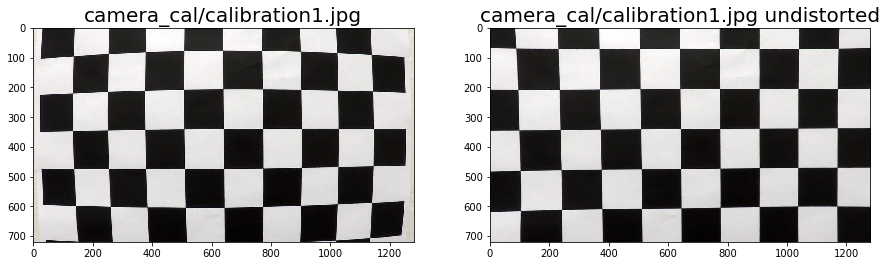

In [2]:
import glob
import os

# Make a list of calibration image files
imgfiles = glob.glob('camera_cal/calibration*.jpg')
imgfiles.sort()

# Get corresponding image files
objpoints, imgpoints, imgsize = getpoints(imgfiles, nx=9, ny=6)

# Compute calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)

# Load a calibration image and undistort it
examplefile = imgfiles[0]
img = mpimg.imread(examplefile)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
ax1.imshow(img)
ax1.set_title(examplefile, fontsize=20)
ax2.imshow(dst)
ax2.set_title(examplefile + ' undistorted', fontsize=20)
name, ext = os.path.splitext(os.path.basename(examplefile))
fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

assert ret, "Problem Calibrating Camera!"

## Pipeline (single images)

<a id='apply_distortion'></a>

### 2. Apply a distortion correction to raw images.

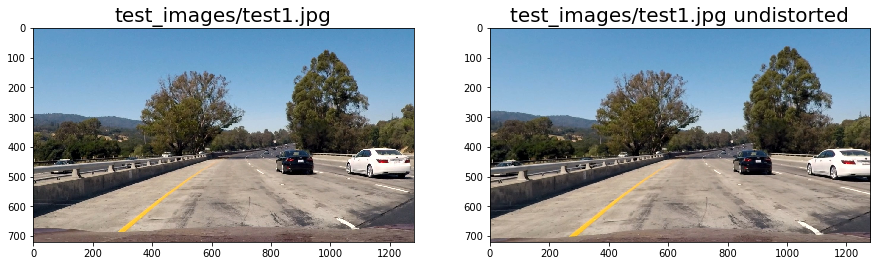

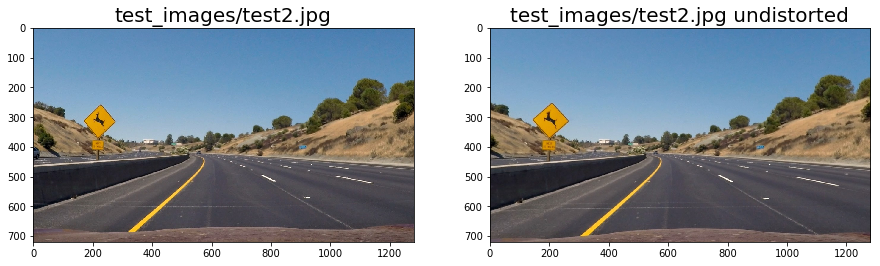

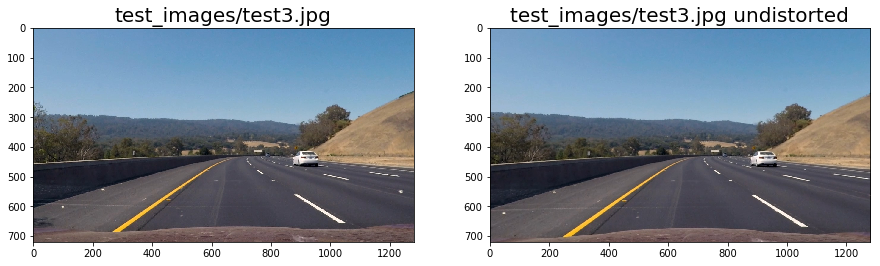

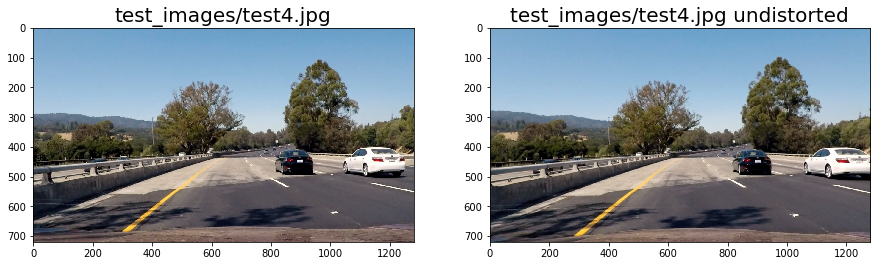

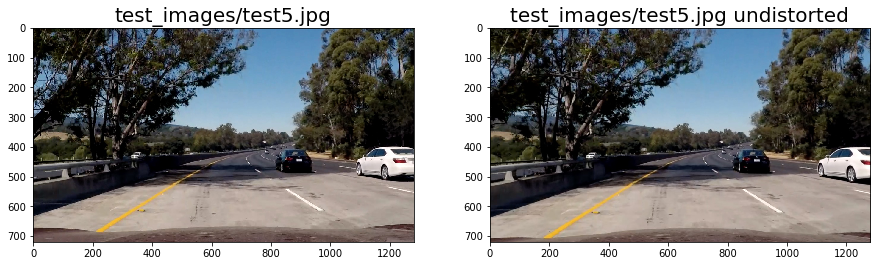

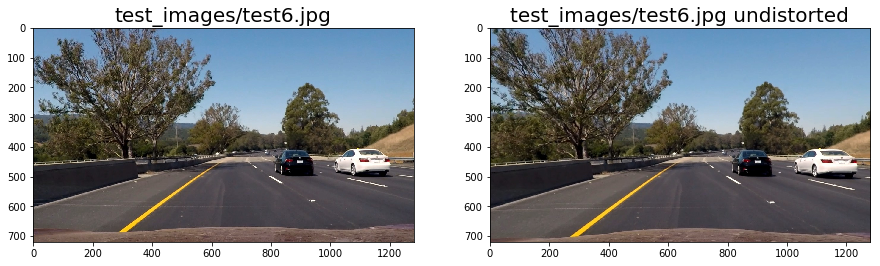

In [3]:
examplefiles = glob.glob('test_images/test*.jpg')

for examplefile in examplefiles:

    # Load a test image and undistort it
    img = mpimg.imread(examplefile)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Plot the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
    ax1.imshow(img)
    ax1.set_title(examplefile, fontsize=20)
    ax2.imshow(dst)
    ax2.set_title(examplefile + ' undistorted', fontsize=20)
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

<a id='create_binary'></a>

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def get_color_channel(img, cvtmode, channel_idx=0):
    '''Apply desired color conversion and return the desired channel'''
    
    # Convert color space
    img_cvt = cv2.cvtColor(img, cvtmode)

    # Select desired color channel
    img_cvt = np.atleast_3d(img_cvt) # in case it's grayscale
    channel_img = img_cvt[:, :, channel_idx]
    
    return channel_img


def deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255),
                     cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x or y, take the absolute value and apply thresholds
       to produce boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the partial derivative wrt x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1)
    else:
        raise ValueError("orient can be 'x' or 'y'")
    
    # Take the absolute value of that partial derivative
    abs_sobel = np.abs(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])
    
    return boolean_mask


def grad_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the magnitude of the gradient
       and apply thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Compute the x and y components of the gradient
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / mag.max())
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])

    return boolean_mask


def grad_dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the gradient direction and apply
       thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (angle > thresh[0]) & (angle < thresh[1])

    return boolean_mask


def color_thresh(img, thresh=(0, 255), cvtmode=cv2.COLOR_RGB2HLS,
                 channel_idx=2):
    '''Optionally convert to another colorspace, then threshold the desired channel
       to produce a boolean pixel mask.
       By default it takes an RGB image, converts it to HLS and thresholds the
       S channel to produce a boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (ch_img > thresh[0]) & (ch_img <= thresh[1])

    return boolean_mask


def get_pixel_mask(img):
    '''Use colorspace conversions, color thresholds and gradients to produce a boolean
       mask of potential lane line pixels.'''
    
    # Create boolean masks using each technique
    x_mask = deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    y_mask = deriv_mag_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    mag_mask = grad_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    dir_mask = grad_dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    color_mask = color_thresh(img, thresh=(170, 255), cvtmode=cv2.COLOR_RGB2HLS, channel_idx=2)

    # Combine the partial derivative and gradient magnitude and direction masks
    grad_mask = (x_mask & y_mask) | (mag_mask & dir_mask)

    # Combine gradient and color masks
    grad_color_mask = grad_mask | color_mask
    
    # Create black and white image of the fully combined mask
    grad_color_img = np.dstack([np.uint8(grad_color_mask*255)]*3)
    
    # Create stacked image of color and grad masks for visualizing the contribution of each
    grad_color_img_stacked = np.dstack((np.zeros_like(grad_mask, np.uint8),
                                np.uint8(grad_mask*255),
                                np.uint8(color_mask*255)))
    
    return grad_color_img, grad_color_img_stacked
    
    

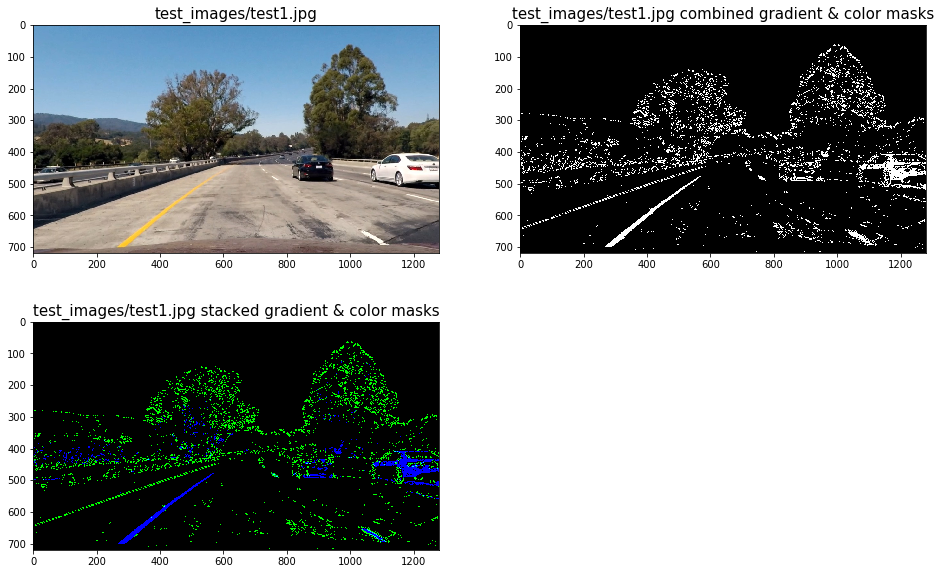

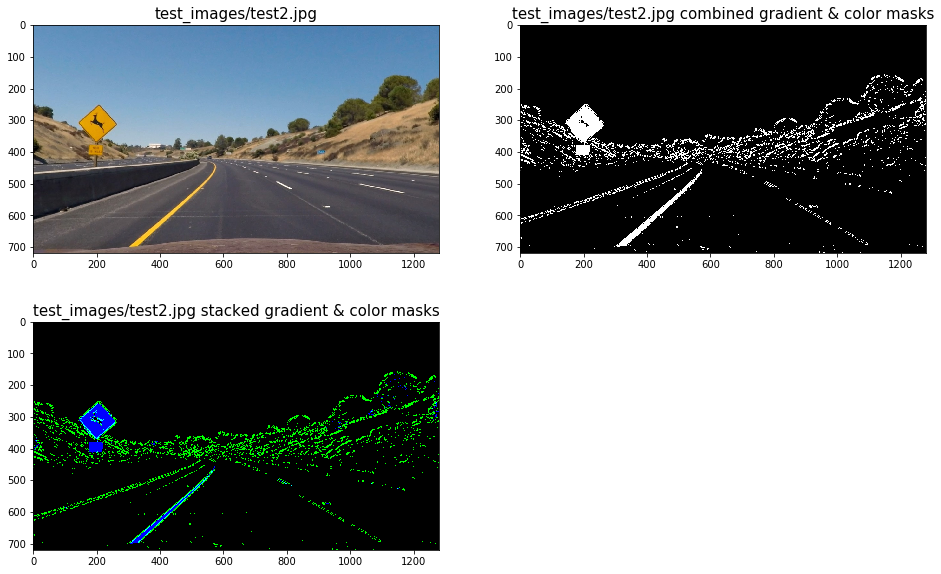

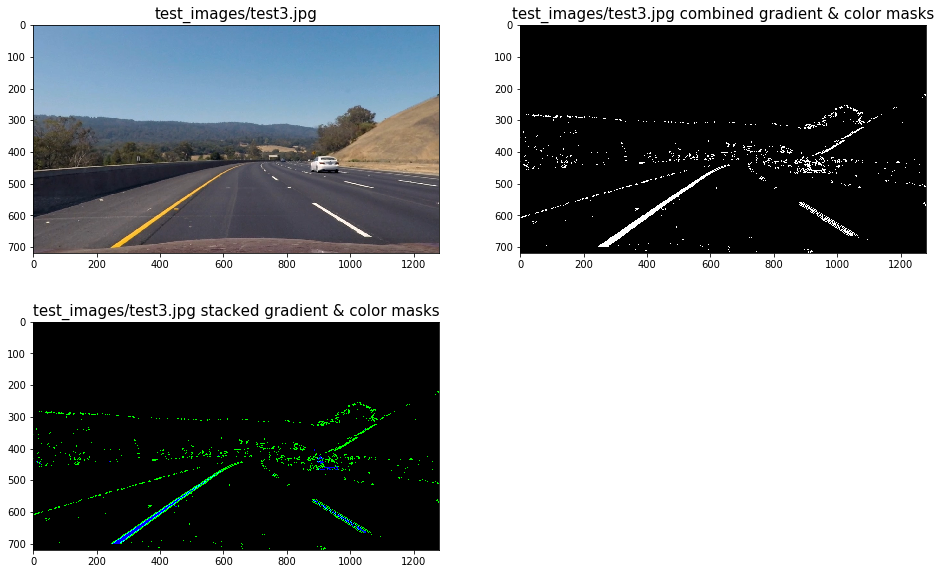

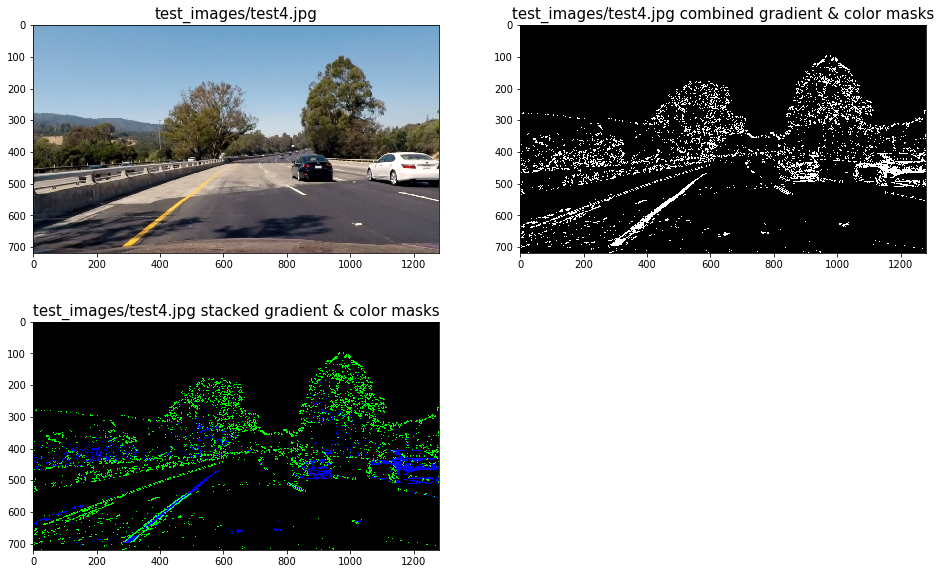

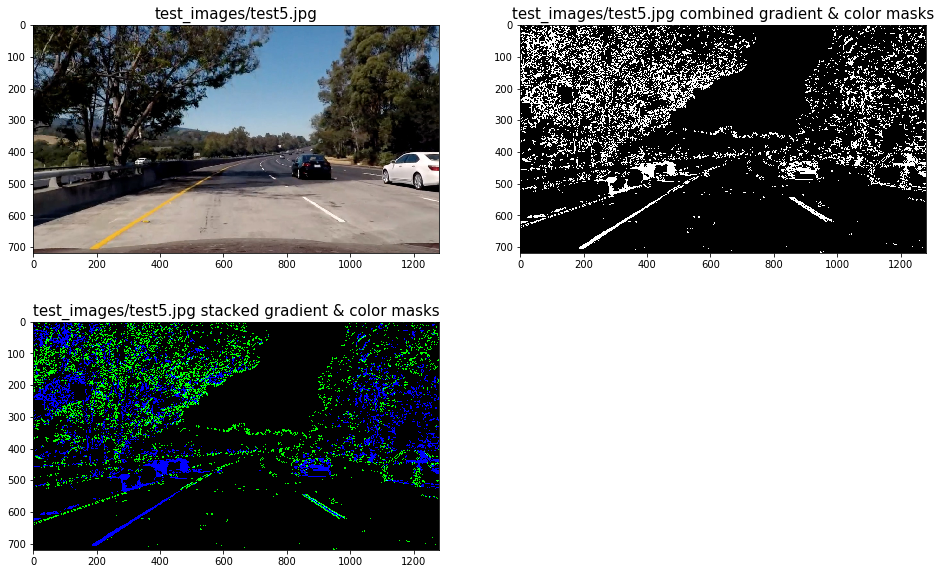

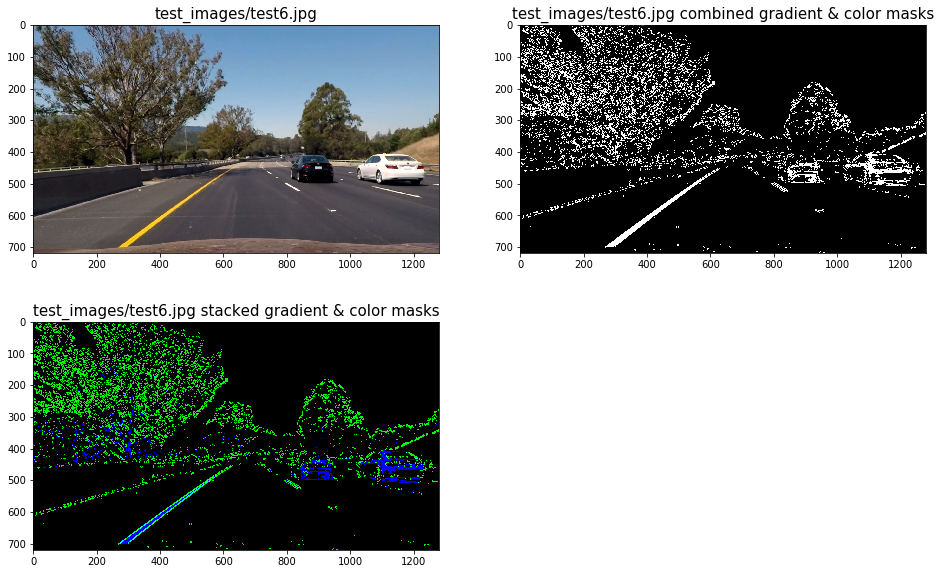

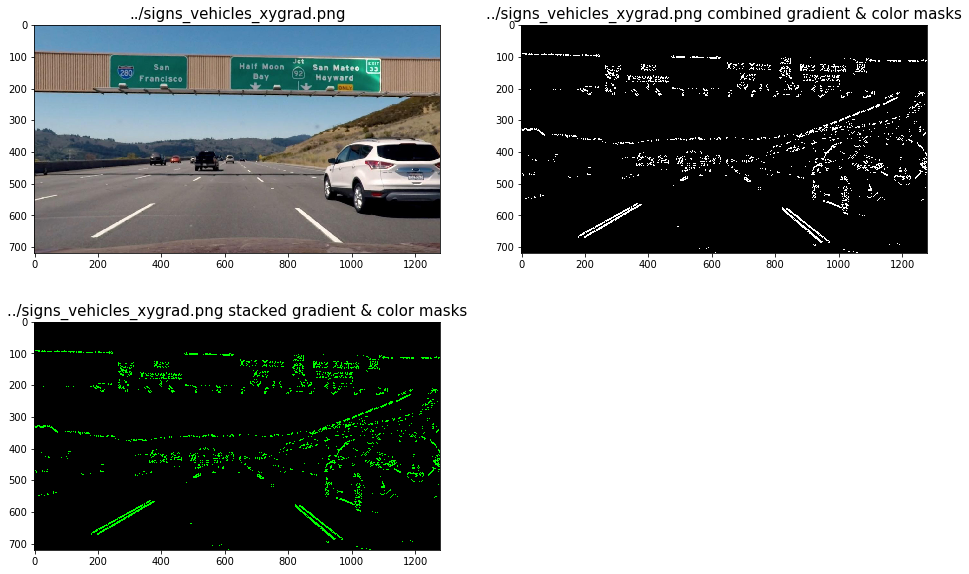

In [5]:
# Load a test image
examplefiles = glob.glob('test_images/test*.jpg') + ['../signs_vehicles_xygrad.png']

for examplefile in examplefiles:
    img = mpimg.imread(examplefile)
    
    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask images
    combined, stacked = get_pixel_mask(dst)

    # Plot the before and after
    fig, ax = plt.subplots(2, 2, figsize=(16,10))
    ax[0,0].imshow(dst)
    ax[0,0].set_title(examplefile, fontsize=15)
    ax[1,0].imshow(stacked)
    ax[1,0].set_title(examplefile + ' stacked gradient & color masks', fontsize=15)
    ax[0,1].imshow(combined)
    ax[0,1].set_title(examplefile + ' combined gradient & color masks', fontsize=15)
    fig.delaxes(ax[1,1])

    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_binary' + ext, bbox_inches='tight')